In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import Tensor

import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from IPython import display

%load_ext autoreload
%autoreload 2

In [2]:
class MasksDataset(data.Dataset):
    def __init__(self, file):
        data = np.load(file)
        
        self.images = self.torch_image(data["images"]) if "images" in data else None
        self.masks  = self.torch_image(data["masks"]) if "masks" in data else None
        self.labels = torch.from_numpy(data["labels"]).cuda() if "labels" in data else None

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return {
            "images": self.images[idx],
            "masks": self.masks[idx] if self.masks is not None else None,
            "labels": self.labels[idx] if self.labels is not None else None
        }
        
    def torch_image(self, img):
        return torch.from_numpy(img.astype(np.float32)).permute(0,3,1,2).cuda()

In [3]:
dir = "data/fashion-masks"

train = MasksDataset(f"{dir}/fashion-masks-train.npz")
dev = MasksDataset(f"{dir}/fashion-masks-dev.npz")
test = MasksDataset(f"{dir}/fashion-masks-test.npz")

In [4]:
def imshow(images, cols=10, figsize=(15,6)):
    n = len(images)
    
    images = images.permute(0,2,3,1).cpu().numpy()
        
    im = images[:,:,:,0]
    
    plt.figure(figsize=figsize)
    
    for i in range(n):
        plt.subplot(n // cols + 1, cols, i + 1)
        plt.axis("off")
        plt.imshow(im[i], cmap="gray")
        
    plt.tight_layout()

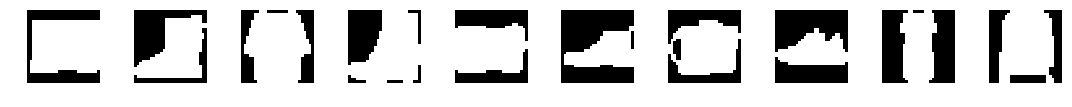

In [5]:
imshow(train.masks[:10])

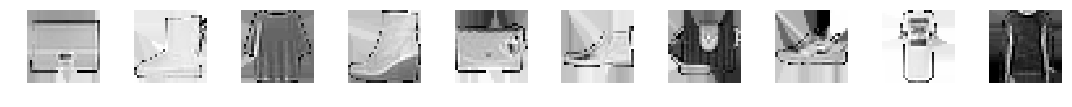

In [6]:
imshow(train.images[:10])

In [58]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
       
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    
    nn.Conv2d(32, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    
    nn.Conv2d(32, 1, 3, padding=1),
    nn.Sigmoid()
)

model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (10): ReLU()
  (11): Upsample(scale_factor=2, mode=nearest)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (14): ReLU()
  (15): Upsample(scale_factor=2, mode=nearest)
  (16): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): Sigmoid()
)

In [59]:
BATCH_SIZE = 128

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
train_loader = data.DataLoader(train, batch_size=BATCH_SIZE)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

losses = []

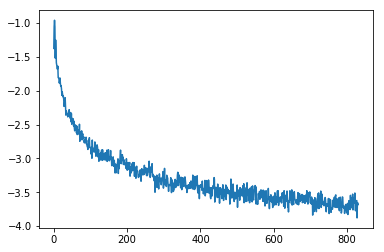

None

0.025179503485560417 1 [0.06634204312890622]


In [60]:
EPOCHS = 2

for epoch in range(EPOCHS):
    for i, batch in enumerate(train_loader):
        scheduler.step()

        images = Variable(batch["images"])
        masks = Variable(batch["masks"])

        y_pred = model(images)
        loss = criterion(y_pred, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(np.log(loss.data[0]))

        if i % 100 == 0 and i > 0:
            plt.plot(losses)
            display.clear_output(wait=True)
            display.display(plt.show())
            print(loss.data[0], epoch, scheduler.get_lr())

In [61]:
NUM_TO_COMPARE=2000

dev_compare = dev[:NUM_TO_COMPARE]["masks"]
gen_compare = model(Variable(dev[:NUM_TO_COMPARE]["images"])).data

a = dev_compare.round().byte()
b = gen_compare.round().byte()

(a & b).float().sum() / (a | b).float().sum()

0.9363673382327277

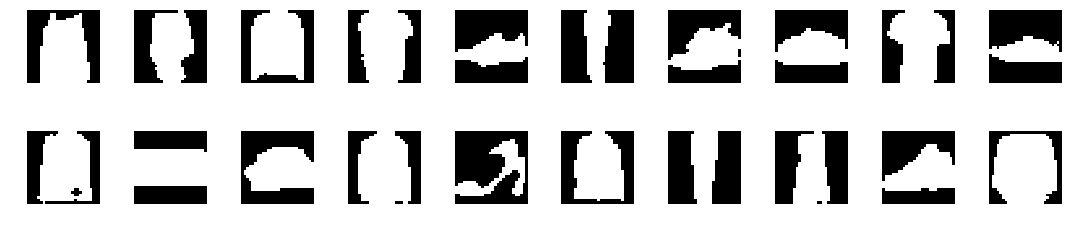

In [62]:
imshow(gen_compare[:20].round(), figsize=(15, 5))

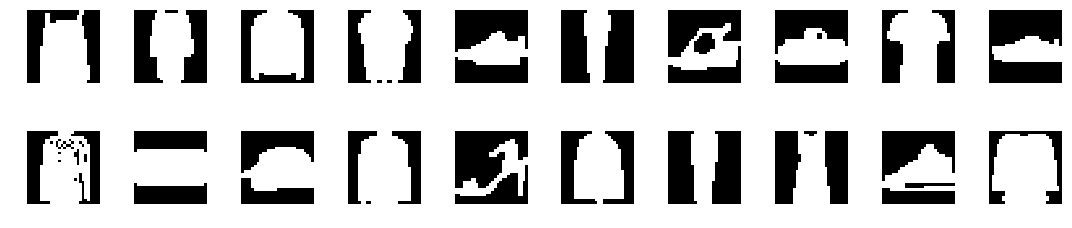

In [63]:
imshow(dev_compare[:20], figsize=(15, 5))